This is a notebook of solving Cahn-Hilliard Equation with GPU. For details about the equation and numerical algorithms, please refer to my CPU version code.

<font color='blue'>Contributor: Qian (Jennifer) Zhang (INL). Email: qian.jennifer.zhang@gmail.com</font>
 
I tried two methods:

Method 1--Leveraging CuPy and let it do the dispatch automatically for me.

Method 2--Noticing there are 1024 threads in each core. I wrote kernal functions to dispatch the job manually.

Here is the result:

For $128\times 128\times 128$ grid size (3000 steps iteration):

1. Numpy CPU: 1063 s

2. CuPy GPU: 9s

3. Method 2 GPU: 0.8s (Accelarating 1500+ times comparing with single CPU, not fair comparision though~~)

For $256\times 256\times 256$ grid size (3000 steps iteration):

1. Numpy CPU:---

2. CuPy GPU: 69s

3. Method 2 GPU: 6s 

In [1]:
import cupy as cp

In [2]:
##Check computational resource

import pyopencl as cl

platforms = cl.get_platforms()
for platform in platforms:
    devices = platform.get_devices()
    for device in devices:
        print(f"Device Name: {device.name}")
        print(f"Device Type: {cl.device_type.to_string(device.type)}")
        print(f"Compute Units (similar to cores): {device.max_compute_units}")

Device Name: Tesla V100-SXM2-32GB
Device Type: ALL | GPU
Compute Units (similar to cores): 80


In [9]:
##Code 1: CuPy automatically
import cupy  as cp
import matplotlib.pyplot as plt
#from numpy.random import *

class solver_CH():
    def __init__(self,rho,kappa,M,ca,cb):
        self.rho = rho
        self.kappa = kappa
        self.M = M
        self.ca = ca
        self.cb = cb
        
    def dfchemdc(self,w):
        return 2.0*self.rho*(w-self.ca)*(w-self.cb)*(2.0*w-self.ca-self.cb)
    
    def delta_c(self,w,dxx):
        nx = w.shape[0]
        ny = w.shape[1]
        nz = w.shape[2]
        
        #initialize intermediate values
        w_x_pre = cp.zeros((nx,ny,nz))
        w_x_la = cp.zeros((nx,ny,nz))
        w_y_pre = cp.zeros((nx,ny,nz))
        w_y_la = cp.zeros((nx,ny,nz))
        w_z_pre = cp.zeros((nx,ny,nz))
        w_z_la = cp.zeros((nx,ny,nz))
        
        # periodic boundary condition in x direction
        w_x_pre[0:nx-1,:,:] = w[1:nx,:,:] 
        w_x_pre[nx-1,:,:] = w[0,:,:]
        
        w_x_la[1:nx,:,:] = w[0:nx-1,:,:] 
        w_x_la[0,:,:] = w[nx-1,:,:]
        
        # periodic boundary condition in z direction
        w_z_pre[:,:,0:nz-1] = w[:,:,1:nz] 
        w_z_pre[:,:,nz-1] = w[:,:,0]
        
        w_z_la[:,:,1:nz] = w[:,:,0:nz-1] 
        w_z_la[:,:,0] = w[:,:,nz-1]
        
        # periodic boundary condition in y direction
        w_y_pre[:,0:ny-1,:] = w[:,1:ny,:] 
        w_y_pre[:,ny-1,:] = w[:,0,:]
        
        w_y_la[:,1:ny,:] = w[:,0:ny-1,:] 
        w_y_la[:,0,:] = w[:,ny-1,:]
        
        #dxx=1/dx**2
        return (w_x_la-2*w+w_x_pre)*dxx+(w_y_la-2*w+w_y_pre)*dxx+(w_z_la-2*w+w_z_pre)*dxx
        
    
    def Solve_CH(self,dt,dxx,c):
        nx = c.shape[0]
        ny = c.shape[1]
        nz = c.shape[2]
        
        mu = cp.zeros((nx,ny,nz))
        c_new = cp.zeros((nx,ny,nz))
        
        mu = self.dfchemdc(c)-self.kappa*self.delta_c(c,dxx)     
        #print('max dfchemdc=',(self.dfchemdc(c)).max())
        #print('min dfchemdc=',(self.dfchemdc(c)).min())
        c_new = c + dt*self.M*self.delta_c(mu,dxx)
        return c_new

In [10]:
def initial_cond(nx,ny,nz):
    c_init = 0.5 + cp.random.randn(nx, ny, nz)*0.05
#    c_init = 0.3 + np.random.uniform(-1,1,size=(nx,ny))*0.01
    return c_init

In [11]:
import numpy as nmp

def visualize_3d(c_init,n):
    c_init=c_init.get()
    x, y, z = nmp.meshgrid(nmp.arange(c_init.shape[0]),
                      nmp.arange(c_init.shape[1]),
                      nmp.arange(c_init.shape[2]))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Flatten the arrays to 1D
    x = x.flatten()
    y = y.flatten()
    z = z.flatten()
    data = c_init.flatten()

    # Scatter plot
    ax.scatter(x, y, z, c=data, cmap='bwr')

    # Add labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    
    # Add title
    ax.set_title('concentration at T='+str(n))

    # Show the plot
    plt.show()

In [19]:
## Set up inital condition

nx = 256
ny = 256
nz = 256
c_new = cp.zeros((nx,ny,nz)) # zero clear
c_init = initial_cond(nx,ny,nz)

In [20]:
## Test on method 1:
import time

nsteps = 3000
Solver = solver_CH(5,2,5,0.3,0.7)
time_start=time.time()
for nstep in range(1,nsteps+1):
    c_new = Solver.Solve_CH(1e-5,1,c_init)
    c_init[:,:,:] = c_new[:,:,:]
time_end=time.time()
print('runnig time=',time_end-time_start)

runnig time= 69.80781745910645


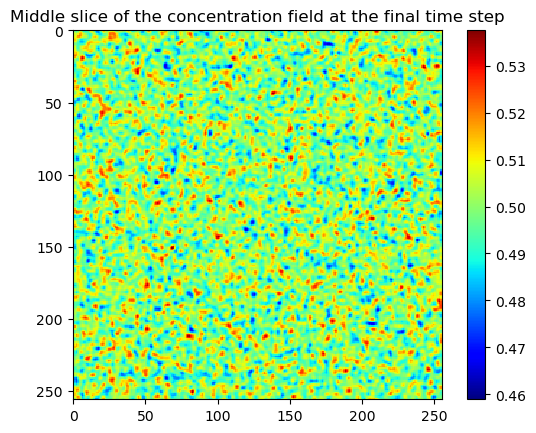

In [21]:
# Visualization: Take a slice of the 3D data and visualize it
slice_index = nz // 2  # Take the middle slice along the z-axis
c_slice = c_init[:, :, slice_index].get()  # Transfer the slice to CPU for visualization

plt.imshow(c_slice, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.title('Middle slice of the concentration field at the final time step')
plt.show()

In [33]:
## Code 2: Manualy dispatch 

# Define the CUDA kernel as a raw string for 3D Laplacian
laplacian_kernel_3d = cp.RawKernel(r'''
extern "C" __global__
void laplacian_kernel_3d(const double* c, double* lap_c, const int nx, const int ny, const int nz, const double dx, const double dy, const double dz) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    int k = blockDim.z * blockIdx.z + threadIdx.z;

    if (i >= nx || j >= ny || k >= nz) return;

    // Compute the index of the current element
    int idx = (k * ny + j) * nx + i;

    // Compute indices for the neighbors with periodic boundary conditions
    int i_left = (i == 0) ? nx - 1 : i - 1;
    int i_right = (i == nx - 1) ? 0 : i + 1;
    int j_up = (j == 0) ? ny - 1 : j - 1;
    int j_down = (j == ny - 1) ? 0 : j + 1;
    int k_front = (k == 0) ? nz - 1 : k - 1;
    int k_back = (k == nz - 1) ? 0 : k + 1;

    // Compute the laplacian
    double lap = (c[(k * ny + j) * nx + i_left] + c[(k * ny + j) * nx + i_right] +
                 c[(k * ny + j_up) * nx + i] + c[(k * ny + j_down) * nx + i] +
                 c[(k_front * ny + j) * nx + i] + c[(k_back * ny + j) * nx + i] -
                 (6.0) * c[idx]) * (dx * dy * dz);

    // Write the result to the output array
    lap_c[idx] = lap;
}
''', 'laplacian_kernel_3d')

# Define the CUDA kernel as a raw string for 3D Laplacian
update_mu = cp.RawKernel(r'''
extern "C" __global__
void update_mu(const double* c, const double* lap_c, double* mu, const double rho, const double ca, const double cb, const double kappa,
const int nx, const int ny, const int nz, const double dx, const double dy, const double dz) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    int k = blockDim.z * blockIdx.z + threadIdx.z;

    if (i >= nx || j >= ny || k >= nz) return;

    // Compute the index of the current element
    int idx = (k * ny + j) * nx + i;

    // Compute the mu
    double lap = (2.0*rho*(c[idx]-ca)*(c[idx]-cb)*(2.0*c[idx]-ca-cb)-kappa*lap_c[idx]);

    // Write the result to the output array
    mu[idx] = lap;
}
''', 'update_mu')

# Define the CUDA kernel as a raw string for 3D Laplacian
update_c = cp.RawKernel(r'''
extern "C" __global__
void update_c(const double* c, const double* lap_c, double* c_new, const double dt, const double M, const int nx, const int ny, const int nz, 
const double dx, const double dy, const double dz) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    int k = blockDim.z * blockIdx.z + threadIdx.z;

    if (i >= nx || j >= ny || k >= nz) return;

    // Compute the index of the current element
    int idx = (k * ny + j) * nx + i;

    // Update c
    double lap = c[idx] + dt*M*lap_c[idx];

    // Write the result to the output array
    c_new[idx] = lap;
}
''', 'update_c')

# Parameters 
nx, ny, nz = 256, 256, 256  # Grid size for 3D
dxx, dyy, dzz = cp.float64(1.0), cp.float64(1.0), cp.float64(1.0)  # Grid spacing for 3D dxx=1/dx, dyy=1/dy, dzz=1/dz
M = cp.float64(5.0)  # Mobility
kappa = cp.float64(2.0)  # Small positive constant
rho = cp.float64(5.0)
dt = cp.float64(0.00001)  # Time step
ca = cp.float64(0.3)
cb = cp.float64(0.7)


# Initialize the concentration field 
c = initial_cond(nx,ny,nz)

# Allocate memory for inter variables
mu = cp.empty_like(c)
lap_c = cp.empty_like(c)

#Remove the redudant ones
#c_new = cp.empty_like(c)
#lap_mu = cp.empty_like(c)


# Define block and grid sizes for 3D
block_size_3d = (8, 8, 8)
grid_size_3d = ((nx + block_size_3d[0] - 1) // block_size_3d[0],
                (ny + block_size_3d[1] - 1) // block_size_3d[1],
                (nz + block_size_3d[2] - 1) // block_size_3d[2])

# Time-stepping loop for 3D Cahn-Hilliard equation
start_time=time.time()

for t in range(3000):
    # Compute the Laplacian of c
    laplacian_kernel_3d(grid_size_3d, block_size_3d, (c, lap_c, nx, ny, nz, dxx, dyy, dzz))
    # Compute the chemical potential mu
    update_mu(grid_size_3d, block_size_3d, (c, lap_c, mu, rho, ca, cb, kappa, nx, ny, nz, dxx, dyy, dzz))
    # Compute the Laplacian of mu
    laplacian_kernel_3d(grid_size_3d, block_size_3d, (mu, lap_c, nx, ny, nz, dxx, dyy, dzz))
    # Compute the next step c
    c = c + dt*M*lap_c
    #update_c(grid_size_3d, block_size_3d, (c, lap_c, c_new, dt, M, nx, ny, nz, dx, dy, dz))
    # Update c
    #c = c_new
    
end_time=time.time()
print('time spent',end_time-start_time)

time spent 6.2064032554626465


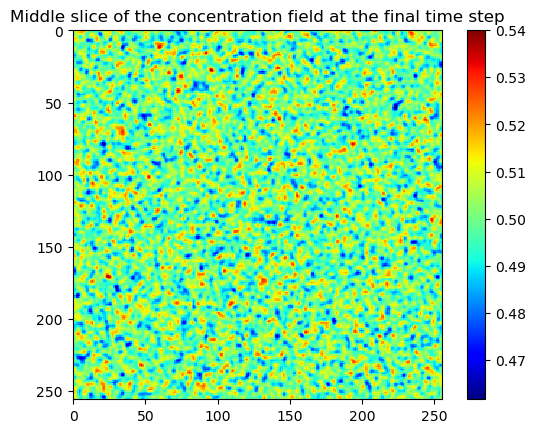

In [23]:
# Visualization: Take a slice of the 3D data and visualize it
slice_index = nz // 2  # Take the middle slice along the z-axis
c_slice = c[:, :, slice_index].get()  # Transfer the slice to CPU for visualization

plt.imshow(c_slice, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.title('Middle slice of the concentration field at the final time step')
plt.show()

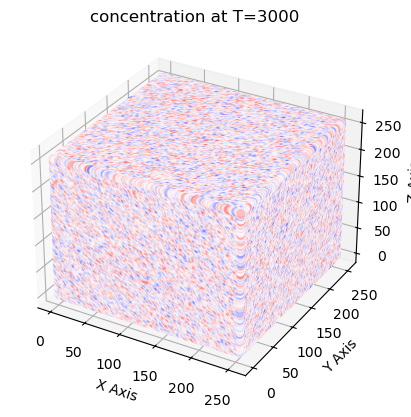

In [24]:
visualize_3d(c,3000)

In [28]:
##Adjust the block size to achieve optimal perforamnce
# Initialize the concentration field 
nx, ny, nz = 128, 128, 128
c = initial_cond(nx,ny,nz)

# Allocate memory for inter variables
mu = cp.empty_like(c)
lap_c = cp.empty_like(c)

block_size = []
time_spend = []
for ii in range(2,12,2):
    c = initial_cond(nx,ny,nz)
    block_size_3d = (ii, ii, ii)
    grid_size_3d = ((nx + block_size_3d[0] - 1) // block_size_3d[0],
                    (ny + block_size_3d[1] - 1) // block_size_3d[1],
                    (nz + block_size_3d[2] - 1) // block_size_3d[2])

     # Time-stepping loop for 3D Cahn-Hilliard equation
    start_time=time.time()

    for t in range(3000):
        # Compute the Laplacian of c
        laplacian_kernel_3d(grid_size_3d, block_size_3d, (c, lap_c, nx, ny, nz, dxx, dyy, dzz))
        # Compute the chemical potential mu
        update_mu(grid_size_3d, block_size_3d, (c, lap_c, mu, rho, ca, cb, kappa, nx, ny, nz, dxx, dyy, dzz))
        # Compute the Laplacian of mu
        laplacian_kernel_3d(grid_size_3d, block_size_3d, (mu, lap_c, nx, ny, nz, dxx, dyy, dzz))
        # Compute the next step c
        c = c + dt*M*lap_c
        #update_c(grid_size_3d, block_size_3d, (c, lap_c, c_new, dt, M, nx, ny, nz, dx, dy, dz))
        # Update c
       #c = c_new
    
    end_time=time.time()
    block_size.append(ii**3)
    time_spend.append(end_time-start_time)

In [29]:
time_spend

[3.4757823944091797,
 1.0366370677947998,
 0.8412864208221436,
 0.8166563510894775,
 0.8405053615570068]

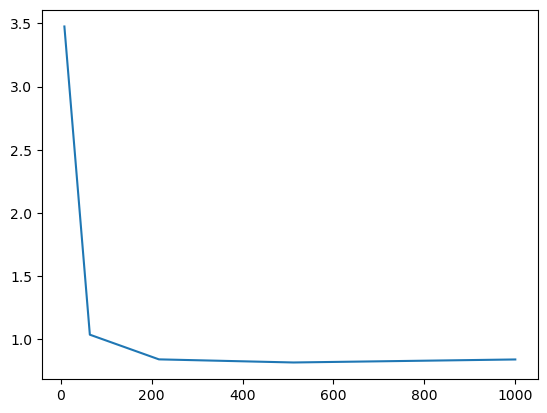

In [30]:
plt.plot(block_size,time_spend)